In [31]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import h5py
from map_coalign import MapSequenceCoalign
import sunpy
import sunpy.map
from glob import glob 
import astropy.units as u
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                      PowerStretch)
from watroo import AtrousTransform, Triangle,denoise
import corner
from sklearn.metrics import r2_score
from image_wavelet import WPSImage
import flow_vis

In [2]:
eui_files = sorted(glob("/home/yjzhu/Solar/EIS_DKIST_SolO/src/EUI/HRI/euv174/20221024/coalign_step_boxcar/*.fits"))
eui_map_seq_coalign = sunpy.map.Map(eui_files[:])
eui_map_seq_coalign = MapSequenceCoalign(eui_map_seq_coalign)

In [3]:
eui_map_seq_coalign_crop = eui_map_seq_coalign.submap(bottom_left=[500,600]*u.pix,top_right=[670,760]*u.pix)

In [4]:
with h5py.File('/home/yjzhu/Solar/EIS_DKIST_SolO/sav/optical_flow/of_east_1.h5','r') as f:
    of_east_1_array = f['of_east_1'][:]

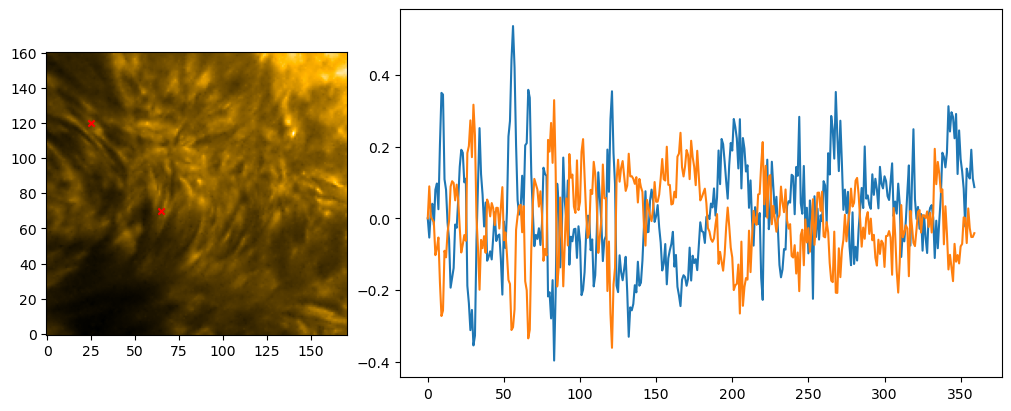

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),layout='constrained',
                              width_ratios=[1,2])

x_select, y_select = [25, 65], [120, 70]

ax1.imshow(denoise(eui_map_seq_coalign_crop[181].data, [5,3], Triangle),origin='lower',
           aspect=1,cmap='sdoaia171')

ax1.scatter(x_select, y_select, s=20, c='r', marker='x')

ax2.plot(of_east_1_array[y_select[0],x_select[0],0,:],label='x_shift')
ax2.plot(of_east_1_array[y_select[0],x_select[0],1,:],label='y_shift')

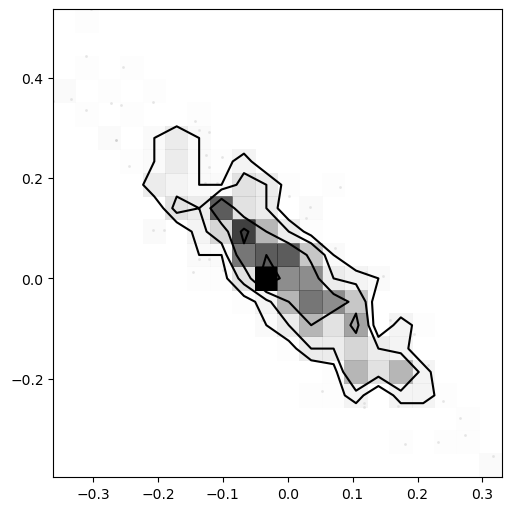

In [6]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')
corner.hist2d(of_east_1_array[y_select[0],x_select[0],1,:], of_east_1_array[y_select[0],x_select[0],0,:])

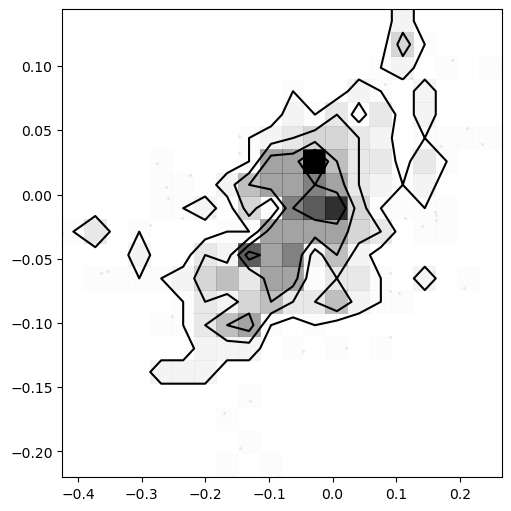

In [7]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')
corner.hist2d(of_east_1_array[y_select[1],x_select[1],1,:], of_east_1_array[y_select[1],x_select[1],0,:])

In [85]:
def fit_direction(flow,):
    ny, nx = flow.shape[0:2]
    flow_direction = np.nan*np.ones((ny,nx))
    flow_direction_r2 = np.nan*np.ones((ny,nx))

    for ii in range(ny):
        for jj in range(nx):
            flow_x, flow_y = flow[ii,jj,1,:], flow[ii,jj,0,:]
            p = Polynomial.fit(flow_x, flow_y, 1,)
            r2 = r2_score(flow_y, p(flow_x))
            flow_direction[ii,jj] = np.rad2deg(np.arctan(p.convert().coef[1]))
            flow_direction_r2[ii,jj] = r2

    return flow_direction, flow_direction_r2
    

In [86]:
of_east_1_direction, of_east_1_direction_r2 = fit_direction(of_east_1_array)

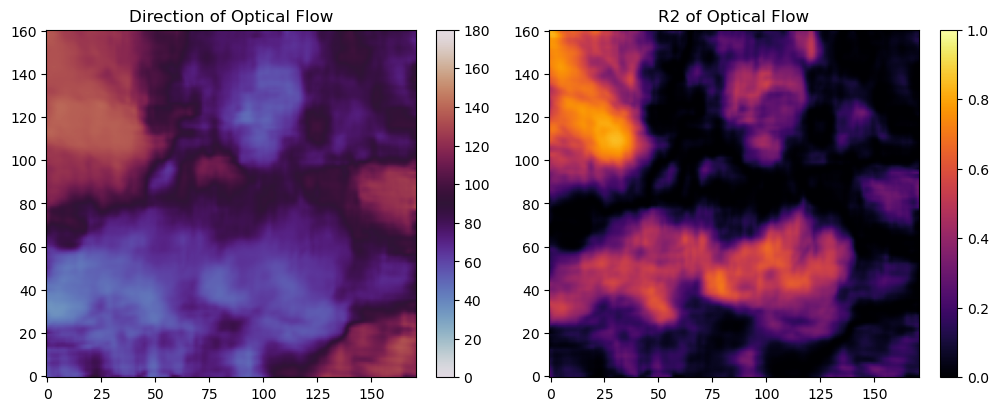

In [87]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),layout='constrained')

im1 = ax1.imshow(90 - of_east_1_direction, origin='lower', cmap='twilight', vmin=0, vmax=180,
                 aspect=1)
ax1.set_title('Direction of Optical Flow')

plt.colorbar(im1)

im2 = ax2.imshow(of_east_1_direction_r2, origin='lower', cmap='inferno', vmin=0, vmax=1,
                 aspect=1)
ax2.set_title('R2 of Optical Flow')

plt.colorbar(im2)

116 152
23.173953915548257 0.34533531452189836


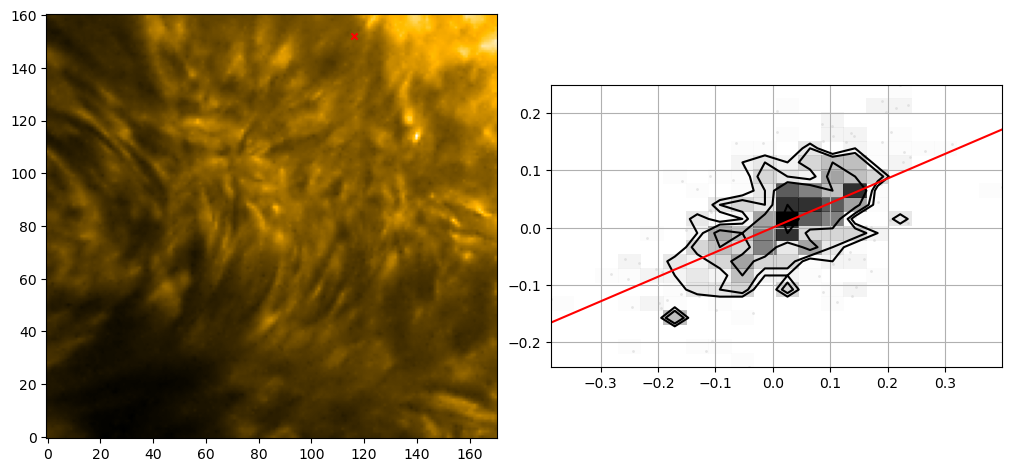

In [88]:
x_random, y_random = np.random.randint(0,169), np.random.randint(0,159)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),layout='constrained')
ax1.imshow(denoise(eui_map_seq_coalign_crop[181].data, [5,3], Triangle),origin='lower',
           aspect=1,cmap='sdoaia171')
ax1.scatter(x_random, y_random, s=20, c='r', marker='x')
corner.hist2d(of_east_1_array[y_random,x_random,1,:], of_east_1_array[y_random,x_random,0,:],ax=ax2,)
ax2.set_aspect('equal', 'box')
ax2.axline((0,0), slope=np.tan(np.deg2rad(of_east_1_direction[y_random,x_random])), color='r')
ax2.grid('on')
print(x_random, y_random)
print(of_east_1_direction[y_random,x_random], of_east_1_direction_r2[y_random,x_random])

In [89]:
of_east_1_direction_masked = np.copy(of_east_1_direction)
of_east_1_direction_masked[of_east_1_direction_r2<0.1] = np.nan

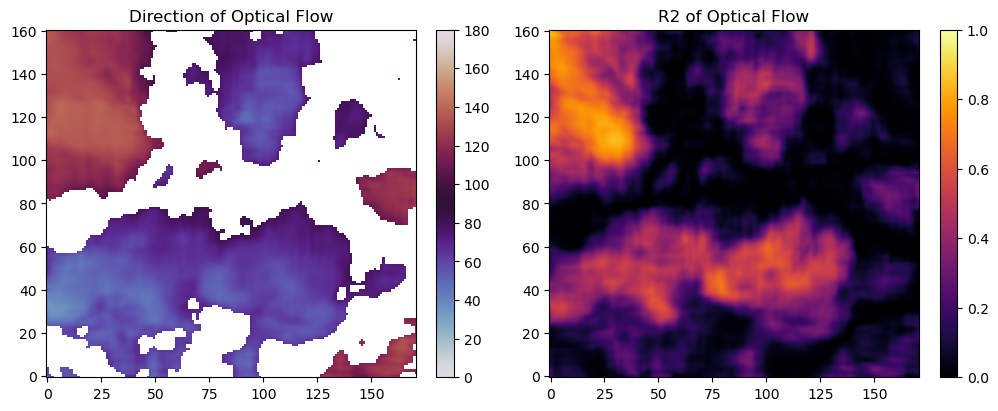

In [90]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),layout='constrained')

im1 = ax1.imshow(90 - of_east_1_direction_masked, origin='lower', cmap='twilight', vmin=0, vmax=180,
                 aspect=1)
ax1.set_title('Direction of Optical Flow')

plt.colorbar(im1)

im2 = ax2.imshow(of_east_1_direction_r2, origin='lower', cmap='inferno', vmin=0, vmax=1,
                 aspect=1)
ax2.set_title('R2 of Optical Flow')

plt.colorbar(im2)

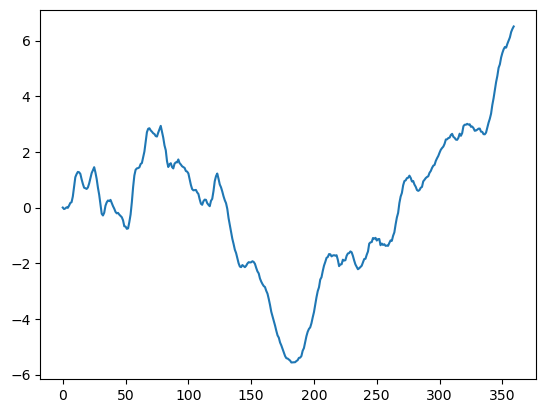

In [91]:
plt.plot(np.cumsum(of_east_1_array[y_select[0],x_select[0],0,:]),label='x_shift')

In [92]:
def get_std_and_mean_from_mapseq(map_seq):
    map_array = map_seq.as_array()
    map_mean = np.nanmean(map_array,axis=2)
    map_std = np.nanstd(map_array,axis=2)

    return map_mean, map_std

In [93]:
east_1_mean, east_1_std = get_std_and_mean_from_mapseq(eui_map_seq_coalign_crop)

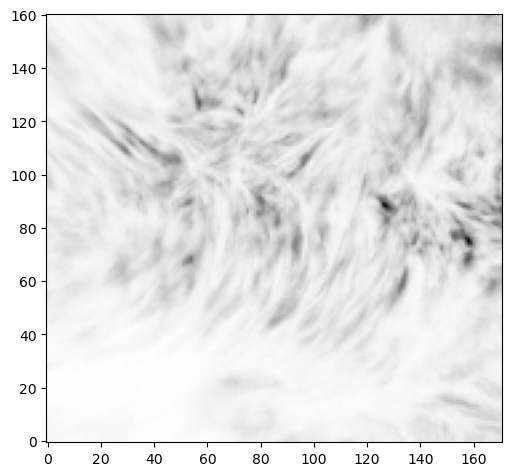

In [94]:
fig, ax = plt.subplots(figsize=(5,5),layout='constrained')

ax.imshow(east_1_std, origin='lower', cmap='Greys', aspect=1)

In [95]:
def flow_direction_and_std_to_hsv(flow_direction, flow_r2, map_std, map_mean, cv_power_index=2,):
    map_cv = map_std/map_mean
    map_cv = ImageNormalize(map_cv, stretch=PowerStretch(cv_power_index))(map_cv)*flow_r2

    fake_direction = 90. - flow_direction

    fake_flow = map_cv[:,:,None]*np.stack([np.sin(np.deg2rad(fake_direction*2)), np.sin(np.deg2rad(fake_direction*2))],axis=2)

    hsv = flow_vis.flow_to_color(fake_flow, convert_to_bgr=False)

    return hsv

In [96]:
east_1_hsv = flow_direction_and_std_to_hsv(of_east_1_direction, of_east_1_direction_r2 , east_1_std, east_1_mean, cv_power_index=1)

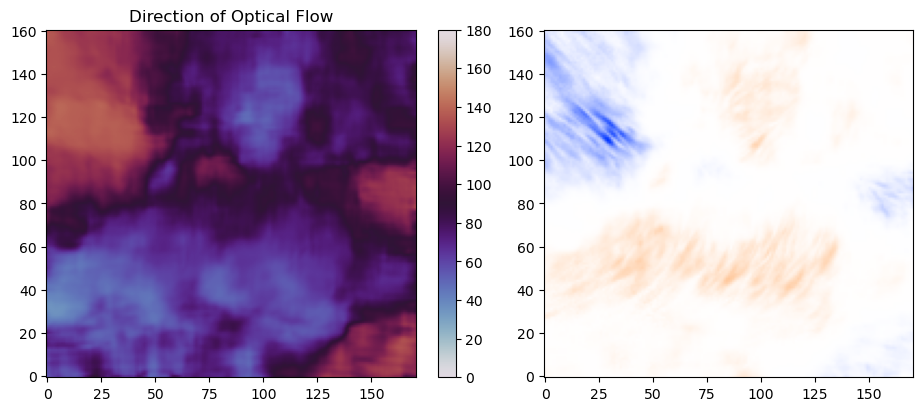

In [97]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),layout='constrained')

im1 = ax1.imshow(90 - of_east_1_direction, origin='lower', cmap='twilight', vmin=0, vmax=180,
                 aspect=1)
ax1.set_title('Direction of Optical Flow')

plt.colorbar(im1)

im2 = ax2.imshow(east_1_hsv, origin='lower', aspect=1)

In [46]:
def draw_hsv_color_wheel(ax,vmin=0,vmax=1.5,samples=1024,clip_circle=True,rr_power_index=2):
    xx, yy = np.meshgrid(
    np.linspace(0, vmax, samples), np.linspace(-vmax, vmax, samples))

    rr = np.sqrt(xx**2 + yy**2) 
    power_norm = ImageNormalize(rr, stretch=PowerStretch(rr_power_index))
    rr = power_norm(rr)

    direction = np.pi/2 - np.arctan2(yy, xx)

    xx_value = rr*np.sin(direction*2)
    yy_value = rr*np.cos(direction*2)

    color_wheel_rgb = flow_vis.flow_to_color(np.dstack((xx_value,yy_value)))

    if clip_circle == True:
        color_wheel_rgb[rr > power_norm(vmax)] = 255
        color_wheel_a = np.where(rr > power_norm(vmax), 255, 255)
    else:
        color_wheel_a = np.ones(rr.shape)*255

    color_wheel_rgba = np.dstack((color_wheel_rgb,color_wheel_a))

    ax.imshow(color_wheel_rgba,extent=(0,vmax,-vmax,vmax),origin="lower")

    ax.set_axis_off()

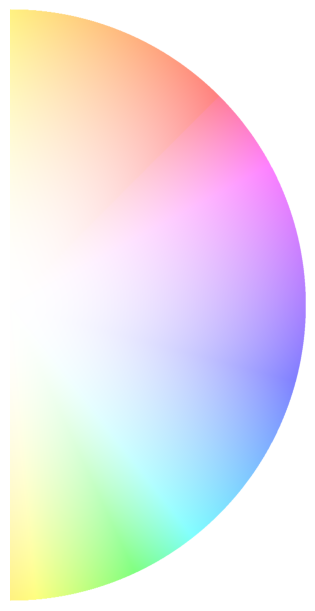

In [47]:
fig, ax = plt.subplots(figsize=(6,6),layout='constrained')

color_wheel_rgba = draw_hsv_color_wheel(ax,clip_circle=True)

In [19]:
eui_map_seq_coalign_crop_west_1 = eui_map_seq_coalign.submap(bottom_left=[1700,500]*u.pix,top_right=[1970,800]*u.pix)

In [20]:
with h5py.File('/home/yjzhu/Solar/EIS_DKIST_SolO/sav/optical_flow/of_west_1.h5','r') as f:
    of_west_1_array = f['of_west_1'][:]

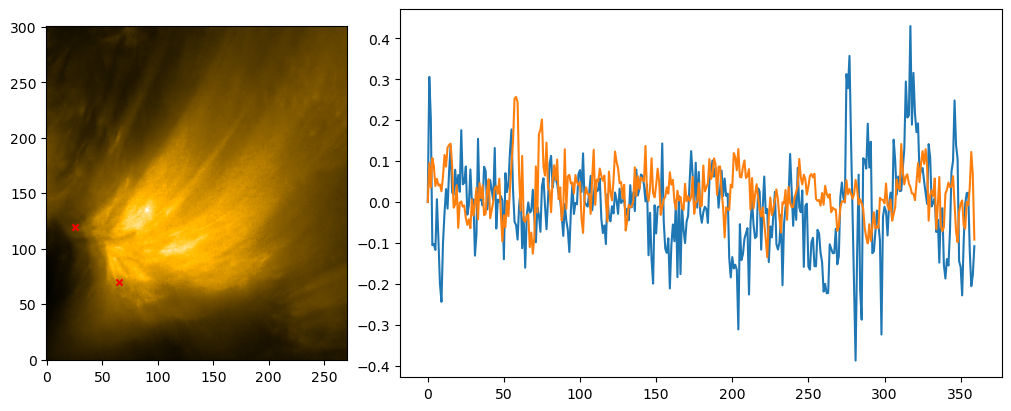

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),layout='constrained',
                              width_ratios=[1,2])

x_select_west_1, y_select_west_1 = [25, 65], [120, 70]

ax1.imshow(denoise(eui_map_seq_coalign_crop_west_1[181].data, [5,3], Triangle),origin='lower',
           aspect=1,cmap='sdoaia171')

ax1.scatter(x_select_west_1, y_select_west_1, s=20, c='r', marker='x')

ax2.plot(of_west_1_array[y_select_west_1[0],x_select_west_1[0],0,:],label='x_shift')
ax2.plot(of_west_1_array[y_select_west_1[0],x_select_west_1[0],1,:],label='y_shift')

In [22]:
of_west_1_direction, of_west_1_direction_r2 = fit_direction(of_west_1_array)

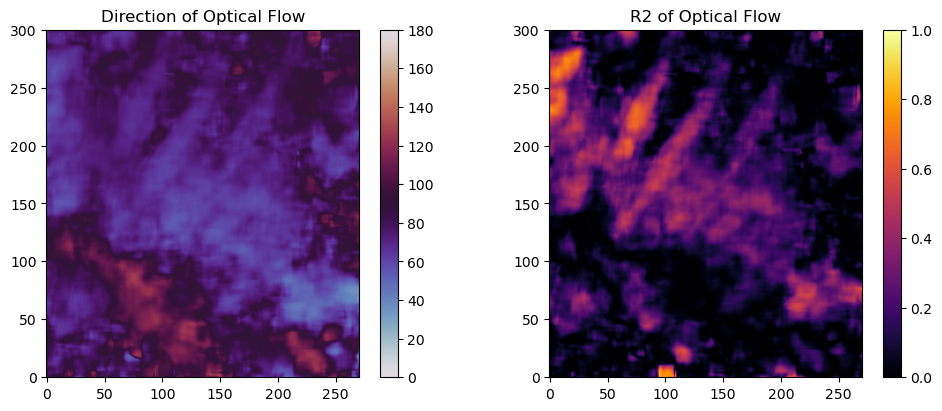

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),layout='constrained')

im1 = ax1.imshow(90 - of_west_1_direction, origin='lower', cmap='twilight', vmin=0, vmax=180,
                 aspect=1)
ax1.set_title('Direction of Optical Flow')

plt.colorbar(im1)

im2 = ax2.imshow(of_west_1_direction_r2, origin='lower', cmap='inferno', vmin=0, vmax=1,
                 aspect=1)
ax2.set_title('R2 of Optical Flow')

plt.colorbar(im2)